In [1]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import scipy
import scipy.io
from tqdm import tqdm
import matplotlib.pyplot as plt

tf.random.set_seed(1234)
np.random.seed(1234)

import os
import time

from unconstrained.svmd import svmd_update
from unconstrained.svgd import svgd_update
from unconstrained.kernel import imq, rbf

In [2]:
data = scipy.io.loadmat('lr/covertype.mat')
X_input = data['covtype'][:, 1:10]
y_input = data['covtype'][:, 0]
y_input[y_input == 2] = 0
X_input = np.hstack([X_input, np.ones([len(X_input), 1])]).astype(np.float64)
y_input = y_input.astype(np.float64)
x_train, x_test, y_train, y_test = train_test_split(X_input, y_input, test_size=0.2, random_state=1)
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.1, random_state=1)
N = 2000
x_train, y_train = x_train[:N], y_train[:N]
x_valid, y_valid = x_valid[:N], y_valid[:N]
x_test, y_test = x_test[:N], y_test[:N]
print("train:", x_train.shape)
N, D = x_train.shape

train: (2000, 10)


In [3]:
class LogisticRegression:
    def __init__(self, n_particles, D):
        self.D = D
        initializer = tf.initializers.GlorotUniform()
        self.w = tf.Variable(initial_value=initializer(shape=[n_particles, D], dtype=tf.float64), dtype=tf.float64, name='w')
        # self.G = tf.Variable(initial_value=tf.ones([n_particles, D, D]), trainable=False, dtype=tf.float64)
        # self.grad_G = tf.Variable(initial_value=tf.ones([n_particles, D, D, D]), trainable=False, dtype=tf.float64)

    @tf.function
    def log_p(self, w, X, y):
        # w: [K, D]
        # X: [N, D]
        # y: [N]
        # y_logits: [K, N]
        y_logits = tf.reduce_sum(tf.expand_dims(X, 0) * tf.expand_dims(w, 1), -1)
        y = tf.tile(y[None, :], [y_logits.shape[0], 1])
        # log_py_given_wx: [K]
        log_py_given_wx = -tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(y, y_logits), axis=-1)
        # log_pw: [K]
        log_pw = -self.D / 2. * np.log(2. * np.pi) - 0.5 * tf.reduce_sum(tf.square(w), axis=-1)
        return log_py_given_wx + log_pw


In [4]:
def train(x_train, y_train, method="smvd", n_epochs=100, lr=1e-4, batch_size=2000):
    def compute_ll_acc(y_prob, y):
        # y_pred: [B]
        y_pred = tf.reduce_mean(y_prob, 0)
        ll = tf.reduce_mean(y * tf.math.log(y_pred + 1e-8) + (1. - y) * tf.math.log(1. - y_pred + 1e-8), axis=0)
        accuracy = tf.reduce_mean(
            tf.cast(
                tf.equal(tf.cast(tf.greater(y, 0.5), tf.int32), 
                            tf.cast(tf.greater(y_pred, 0.5), tf.int32)), tf.float64))
        return ll, accuracy
    
    def evaluate(model):
        def get_lik_and_acc(X, y):
            n = X.shape[0]
            ll, acc = [], []
            batch_size = 2000
            for i in range(n // batch_size):
                start = i * batch_size
                end = min((i+1)*batch_size, n)
                x_batch = tf.convert_to_tensor(X[start:end])
                y_batch = tf.convert_to_tensor(y[start:end])

                z = tf.reduce_sum(tf.expand_dims(x_batch, 0) * tf.expand_dims(model.w, 1), -1)
                y_prob = tf.sigmoid(z)
#                 y_pred = tf.reduce_mean(y_prob, 0)
                ll_i, acc_i = compute_ll_acc(y_prob, y)

                ll.append(ll_i.numpy())
                acc.append(acc_i.numpy())
            return np.mean(ll), np.mean(acc)

        train_ll, train_acc = get_lik_and_acc(x_train, y_train)
        valid_ll, valid_acc = get_lik_and_acc(x_valid, y_valid)
        test_ll, test_acc = get_lik_and_acc(x_test, y_test)

        return train_ll, train_acc, valid_ll, valid_acc, test_ll, test_acc

    @tf.function
    def train_one_step(model, optimizer, X, y, step, n_train=None, method="svmd", kernel=rbf):
        with tf.GradientTape() as tape:
            # X: [B, D]
            # y: [B]
            batch_size = tf.cast(tf.shape(X)[0], tf.float64)
            # z: [K, B]
            z = tf.reduce_sum(tf.expand_dims(X, 0) * tf.expand_dims(model.w, 1), -1)
            # y_prob: [K, B]
            y_prob = tf.sigmoid(z)

            # dz: [K, B]
            dz = y_prob * (1. - y_prob)

            # # empirical fisher:
            # # mean_dW: [K, 1, D]
            # mean_dW = tf.reduce_mean(dW, axis=1, keepdims=True)
            # # diff_dW: [K, B, D]
            # diff_dW = dW - mean_dW
            # # emp_cov_dW_: [K, D, D]
            # emp_cov_dW_ = tf.matmul(diff_dW, diff_dW, transpose_a=True) / batch_size
            # cov_dW = emp_cov_dW_

            # fisher: [K, D, D]
            fisher = tf.einsum("kb,bd,bi->kdi", dz, X, X) / batch_size
            cov_dw = fisher

        ll, accuracy = compute_ll_acc(y_prob, y)

        # dW: [K, B, D]
        dw = X[None, :, :] * tf.expand_dims(y - y_prob, 2)

        # w_grads: [K, D]
        if n_train is not None:
            w_grads = tf.reduce_mean(dw, axis=1) * n_train - model.w
        else:
            w_grads = tf.reduce_sum(dw, axis=1) - model.w

        # update covariance
        # rho = tf.minimum(1. - 1. / step, 0.95)
        # model.G.assign(rho * model.G + (1. - rho) * cov_dw)

        # grad_cov_dw; [K, D, D, D]
        grad_cov_dw = tape.batch_jacobian(cov_dw, model.w)
        # model.grad_G.assign(rho * model.grad_G + (1. - rho) * grad_cov_dw)

        H = cov_dw + 1e-3 * tf.eye(model.D, dtype=tf.float64)
        H_inv = tf.linalg.inv(H)
        # grad_G_inv: [K, D, D]
        # grad_H_inv = tf.linalg.diag_part(-tf.einsum("kab,kbcd,kce->kaed", H_inv, model.grad_G, H_inv))
        grad_H_inv = tf.linalg.diag_part(-tf.einsum("kab,kbcd,kce->kaed", H_inv, grad_cov_dw, H_inv))

        if method == "svgd":
            grads = svgd_update(model.w, w_grads, kernel=kernel)
        elif method == "matrix_svgd_avg":
            grads = svgd_update(model.w, w_grads, kernel=kernel)
            grads = tf.matmul(grads, tf.reduce_mean(H_inv, 0))
        elif method == "svmd":
            eta_grads = svmd_update(
                model.w, w_grads, H, H_inv, grad_H_inv, kernel=kernel, n_eigen_threshold=0.98, md=False)
            grads = tf.squeeze(H_inv @ eta_grads[:, :, None], axis=-1)
        else:
            raise NotImplementedError()

        optimizer.apply_gradients([(-1. * grads, model.w)])

        return ll, accuracy

    optimizer = tf.keras.optimizers.SGD(lr)
    step = tf.constant(1., dtype=tf.float64)
    results = []
    for ep in tqdm(range(1, 1 + n_epochs)):
        x_train, y_train = shuffle(x_train, y_train)
        max_batches = N // batch_size 

        for bi in range(max_batches):
            start = bi * batch_size
            end = min((bi + 1) * batch_size, N)

            x_batch = tf.convert_to_tensor(x_train[start:end])
            y_batch = tf.convert_to_tensor(y_train[start:end])

            ll, acc = train_one_step(model, optimizer, x_batch, y_batch, step, n_train=N, method=method, kernel=imq)
            # if step % 20 == 0:
#             print(step.numpy(), evaluate(model))

            step += 1.
        results.append(evaluate(model))
    return results

100%|██████████| 300/300 [00:12<00:00, 24.87it/s]


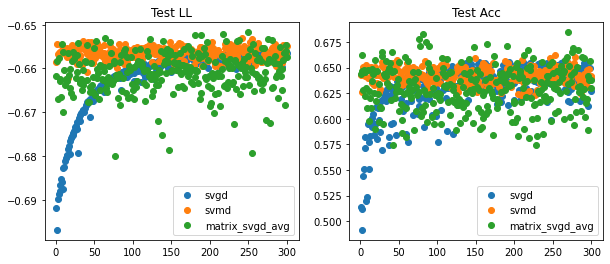

In [5]:
methods = ["svgd", "svmd", "matrix_svgd_avg"]
samples = {}
f, axes = plt.subplots(1, 2, figsize=(5 * 2, 4))
axes[0].set_title("Test LL")
axes[1].set_title("Test Acc")
n_epochs = 300
for method in methods:
    model = LogisticRegression(200, D)
    results = train(x_train, y_train, method=method, n_epochs=n_epochs, lr=3e-4, batch_size=200)
    samples[method] = model.w
    results = np.array(results)
    axes[0].scatter(np.arange(1, n_epochs + 1), results[:, -2], label=method)
    axes[1].scatter(np.arange(1, n_epochs + 1), results[:, -1], label=method)
for ax in axes:
    ax.legend()

In [6]:
x_train = tf.convert_to_tensor(x_train)
y_train = tf.convert_to_tensor(y_train)
# Initialize the HMC transition kernel.
num_results = 100
num_burnin_steps = int(1e3)
num_steps_between_results = 10
adaptive_hmc = tfp.mcmc.DualAveragingStepSizeAdaptation(
    tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=lambda w: model.log_p(w, x_train, y_train),
        num_leapfrog_steps=10,
        step_size=0.1),
    num_adaptation_steps=int(num_burnin_steps * 0.8))

# Run the chain (with burn-in).
@tf.function
def run_chain():
    samples, pkr = tfp.mcmc.sample_chain(
        num_results=num_results,
        num_burnin_steps=num_burnin_steps,
        num_steps_between_results=num_steps_between_results,
        current_state=np.zeros([10, D], dtype=np.float64),
        kernel=adaptive_hmc,
        trace_fn=lambda _, pkr: pkr)
    return samples, pkr

gd_truth_samples, pkr = run_chain()
is_accepted = pkr.inner_results.is_accepted
r_hat = tfp.mcmc.potential_scale_reduction(gd_truth_samples)
print("chain:", gd_truth_samples.shape)
print("acceptance rate:", is_accepted.numpy().mean())
print("R-hat diagnostic (per dim):", r_hat.numpy())

gd_truth_samples = tf.reshape(gd_truth_samples, [-1, D])

chain: (100, 10, 10)
acceptance rate: 0.938
R-hat diagnostic (per dim): [1.00536386 1.01495825 1.00975297 1.00744803 1.00899024 1.01240666
 1.01359974 1.00919957 1.01607286 1.00829065]


In [7]:
methods.append("hmc")

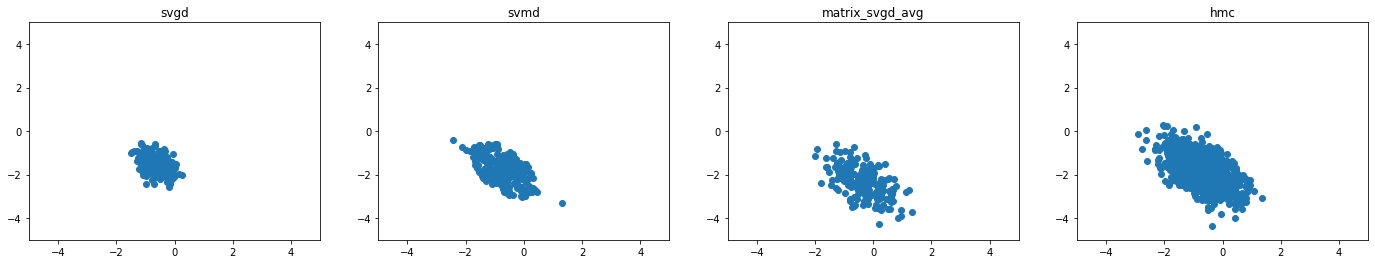

In [8]:
samples["hmc"] = gd_truth_samples
f, axes = plt.subplots(1, len(methods), figsize=(6 * len(methods), 4))
for i, method in enumerate(methods):
    axes[i].set_title(method)
    w = samples[method]
    axes[i].scatter(w[:, 6], w[:, 7])
#     axes[i].set_xlim([1, 5])
#     axes[i].set_ylim([-3, 0])
    axes[i].set_xlim([-5, 5])
    axes[i].set_ylim([-5, 5])